# Intuitive Hierarchical Text-Based Clustering

*Objective* : In this project, I would attempt to create intuitive, hierarchical clusters and topics from companies by extracting information from their descriptions on their websites. 
Basically, the aim is to create hierarchical clusters of companies based on just their descriptions, and then automatically describe the topics of those clusters. 

*Dataset* : We have a group of text files, each text file contains the description/profile of a publicly listed company and each filename consists of the company’s stock ticker. There also is a .csv file containing a referenced list of stock tickers and basic company information which can be useful for data exploration but not used for clustering. 

The entire process has 4 main stages : *Creating the Corpus -> Pre-Processing -> Feature Extraction -> Clustering*


# Table of contents
1. [Creating the corpus](#create corpus)
2. [Pre-Processing](#preprocessing)
3. [Feature Extraction](#feature extraction)
4. [Clustering](#clustering)
    1. [Creating Subclusters - Level 1](#clustering level 1)
    2. [Creating Subclusters - Level 2 ](#clustering level 2)
    3. [Creating Subclusters - Level 3 ](#clustering level 3)
5. [Dataframe containing final result](#final result)
6. [Extras : Using agglomerative clustering instead of K means](Company Clustering-Agglomerative.ipynb)
    
    

First I will load all the packages I will require.

In [2]:
# load required packages
import nltk
from nltk.corpus import PlaintextCorpusReader
import pandas as pd
import re
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.cluster import KMeans
import time
import random

[nltk_data] Downloading package stopwords to C:\Users\Mr.
[nltk_data]     Priyan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


I am going to define all the functions I will need. Don't bother to understand what each function does right now, I will explain them in detail later

In [39]:
# function to unstem the words
def unstem(words,stemmed_vocab = stemmed_vocab):
    words = words.split()
    words = [stemmed_vocab['words'][word][:1][0] for word in words]
    return ' '.join(words)

In [81]:
def find_number_clusters(tfidf):
    wcss = []
    start = time.time()
    for i in range(1, 10):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 10)
        kmeans.fit(tfidf)
        wcss.append(kmeans.inertia_)
    end = time.time()
    print("execution time:",round(((end-start)/60),2),"minutes")
    plt.plot(range(1, 10), wcss)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()  

In [82]:
def apply_kmeans(num_clusters,random_state,tfidf):
    km = KMeans(n_clusters=num_clusters, random_state =random_state)
    km.fit(tfidf)
    clusters = km.labels_.tolist()
    return km,clusters

In [3]:
def print_cluster(df, km, num_clusters, cluster_level, num_cluster_topics=3, num_cluster_companies=2) :
    
    print("Top terms per cluster:")
    print()
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
    for i in range(num_clusters):
        print("Cluster %d words:" % int(i), end='')

        for ind in range(0,num_cluster_topics): # top 6 words per cluster
            print(' %s' % unstem(terms[order_centroids[i,ind]]), end=',')
        print() #add whitespace
        print() #add whitespace

        print("Cluster %d Companies:" % int(i), end='')
        #print()
        for title in df[df[cluster_level]==i]["Company"].sample(num_cluster_companies).values.tolist():
            print(' %s,' % title, end='')
            #uncomment below to see the Sector and Industry of each Company
            #print("Sector:",merged_df.Sector[merged_df.Company==title].values[0],"Industry:",merged_df.Industry[merged_df.Company==title].values[0])
        print() #add whitespace
        print() #add whitespace

    print("Split of classes within clusters:")
    print(df[cluster_level].value_counts())
    

In [92]:
def save_topics(df, km, num_clusters, cluster_level, num_cluster_topics=10) :
    
    if cluster_level=='Clusters':
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            for ind in range(0,num_cluster_topics):                    
                topics_list.append(unstem(terms[order_centroids[i,ind]]))        
            topics_dict.update({str(i):topics_list})    
        return topics_dict
    
    if cluster_level=='Subclusters_level_1':
        level1= df['Clusters'].unique()[0]
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            for ind in range(0,num_cluster_topics):                    
                topics_list.append(unstem(terms[order_centroids[i,ind]]))        
            
            topics_dict.update({str(level1)+str(i):topics_list})
        return topics_dict
    
    if cluster_level=='Subclusters_level_2':
        level1= int(df['Clusters'].unique()[0])
        level2 =int(df['Subclusters_level_1'].unique()[0]) 
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            for ind in range(0,num_cluster_topics):                    
                topics_list.append(unstem(terms[order_centroids[i,ind]]))        
            
            topics_dict.update({str(level1)+str(level2)+str(i):topics_list})
        return topics_dict    
        

In [7]:
def freq_words(indexes,new_corpus,terms,X):
    cluster_descriptions=""
    for i in (indexes):
        cluster_descriptions = cluster_descriptions+new_corpus[i]+" "
    cluster_descriptions=cluster_descriptions[:-1]
    from collections import Counter
    Counter = Counter(cluster_descriptions.split())
    #freq_words has most commonly occuring words within parent cluster ranked in descending order
    freq_words=Counter.most_common()
    # freq_terms has most commonly occuring terms(from tfidf matrix) within parent cluster ranked in descending order along with 
    #frequencies
    freq_terms_with_count = []
    for word in freq_words:
        if word[0] in set(terms):
            freq_terms_with_count.append(word)
    #sorted list of most occuring terms in cluster 3 , subcluster 1
    freq_terms = []
    for i in range(len(freq_terms_with_count)):
        freq_terms.append(freq_terms_with_count[i][0])
    # top X most occuring terms from that cluster
    # here is where you can play around with the X value
    X_freq_terms=freq_terms[0:X]
    return X_freq_terms, freq_terms_with_count   

In [202]:
def print_cluster_words(df, km, num_clusters, cluster_level, words, num_cluster_topics=3, num_cluster_companies=2) :
    
    print("Top terms per cluster:")
    print()
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
    for i in range(num_clusters):
        print("Cluster %d words:" % int(i), end='')        
        flag=0
        ind=0
        while flag < num_cluster_topics: # top n words per cluster
            check_word = terms[order_centroids[i,ind]]
            if check_word not in set(words):
                print(' %s' % unstem(check_word), end=',')
                flag=flag+1
                ind = ind+1
            else:
                ind = ind+1
                    
        print() #add whitespace
        print() #add whitespace

        print("Cluster %d Companies:" % int(i), end='')
        #print()
        for title in df[df[cluster_level]==i]["Company"].sample(num_cluster_companies).values.tolist():
            print(' %s,' % title, end='')
            #uncomment below to see the Sector and Industry of each Company
            #print("Sector:",merged_df.Sector[merged_df.Company==title].values[0],"Industry:",merged_df.Industry[merged_df.Company==title].values[0])
        print() #add whitespace
        print() #add whitespace

    print("Split of classes within clusters:")
    print(df[cluster_level].value_counts())
    

In [244]:
def save_topics_words(df, km, num_clusters, cluster_level, words, num_cluster_topics=10) :
    
    if cluster_level=='Clusters':
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            flag=0
            ind=0
            while flag<num_cluster_topics:
                check_word = terms[order_centroids[i,ind]]
                check_word = check_word.split(' ')            
                if len(set(check_word).intersection(words))==0:
                    topics_list.append(unstem(' '.join(check_word)))
                    flag = flag + 1
                    ind = ind + 1
                else:
                    ind = ind + 1
            topics_dict.update({str(i):topics_list})    
        return topics_dict
    
    if cluster_level=='Subclusters_level_1':
        level1= df['Clusters'].unique()[0]
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            flag = 0
            ind = 0
            while flag<num_cluster_topics:                    
                check_word = terms[order_centroids[i,ind]]
                check_word = check_word.split(' ')            
                if len(set(check_word).intersection(words))==0:
                    topics_list.append(unstem(' '.join(check_word)))
                    flag = flag + 1
                    ind = ind + 1
                else:
                    ind = ind + 1
            
            topics_dict.update({str(level1)+str(i):topics_list})
        return topics_dict
    
    if cluster_level=='Subclusters_level_2':
        level1= int(df['Clusters'].unique()[0])
        level2 =int(df['Subclusters_level_1'].unique()[0]) 
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            flag = 0
            ind = 0
            while flag<num_cluster_topics:
                check_word = terms[order_centroids[i,ind]]
                check_word = check_word.split(' ')            
                if len(set(check_word).intersection(words))==0:
                    topics_list.append(unstem(' '.join(check_word)))
                    flag = flag + 1
                    ind = ind + 1
                else:
                    ind = ind + 1
            
            topics_dict.update({str(level1)+str(level2)+str(i):topics_list})
        return topics_dict
    
    if cluster_level=='Subclusters_level_3':
        level1= int(df['Clusters'].unique()[0])
        level2 =int(df['Subclusters_level_1'].unique()[0])
        level3 =int(df['Subclusters_level_2'].unique()[0])
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            flag = 0
            ind = 0
            while flag<num_cluster_topics:
                check_word = terms[order_centroids[i,ind]]
                check_word = check_word.split(' ')            
                if len(set(check_word).intersection(words))==0:
                    topics_list.append(unstem(' '.join(check_word))) 
                    flag = flag + 1
                    ind = ind + 1
                else:
                    ind = ind + 1
            
            topics_dict.update({str(level1)+str(level2)+str(level3)+str(i):topics_list})
        return topics_dict
    
    
        

## Reading from the text files to create the corpus<a name="create corpus"></a>

Reading dataset using NLTK PlaintextCorpusReader : Each company had a text file containing its description. Each text file was named according to its stock ticker name suffixed with '-profile.txt', for example, the company Apple was named 'AAPL-profile.txt'. So, the NLTK PlaintextCorpusReader read all the company text files into the corpus object.  

In [11]:
#change path below to folder where you place the files
corpus_path = "C:\\Users\\Mr. Priyan\\Dropbox\\Data Science\\DDL\\company_profiles" 
corpus = PlaintextCorpusReader(corpus_path, ".*\.txt")
print("Company Profile Corpus Statistics")
print("Number of profiles: " + str(len(corpus.fileids())))
print("Number of paragraphs: " + str(len(corpus.paras())))
print("Number of sentences: " + str(len(corpus.sents())))
print("Number of words: " + str(len(corpus.words())))

Company Profile Corpus Statistics
Number of profiles: 3558
Number of paragraphs: 3558
Number of sentences: 23988
Number of words: 790836


You can see the statistics above, there are 3,558 company descriptions, 23,988 sentences and 790,836 words in total!

Next we will be proceeding to the Pre-Processing stage, just before that, I will take the company descriptions from the corpus object and put them into a list of lists called list_corpus. The next stage, i.e., pre-preprocessing will be performed on the list_corpus. 

In [115]:
list_corpus = []
#Converting corpus to list of lists
for company_description in corpus.fileids():
    list_corpus.append(list(corpus.words(company_description)))

## Preprocessing the corpus<a name="preprocessing"></a>

Processing needs to be carried out before we can go to the feature extraction stage. The objective of pre-processing is to remove irrelevant parts of the data that adds no value to the feature extraction stage. Consider this stage as removing noise from the data and keeping only the relevant bit.

** Pre-Processing Steps :-**
- **Removing punctuation** : Our objective is to create hierarchical clusters of companies from just their descriptions, and then automatically describe the topics of those clusters. Topics are essentially just a collections of words which can uniquely describe each cluster. Thus, we need to remove any kinds of punctuation from the company descriptions, as that is just irrelevant noise. 
- **Converting to lowercase** : Each topics has to be unique, although in the company descriptions, the same word, say 'bank' can exist as 'Bank' and 'bank'. We need our system to recognise the two words to be the same. Thus, we convert all words to lowercase in order to avoid duplication of topics.
- **Stemming** : The same word, say 'organize' can be written in different forms(singular, plural, tenses) such as 'organizes', 'organizing', 'organized', etc. When stemming is performed on the word 'organize' and the three forms above, all of them gets reduced to 'organiz'. Again, by doing this we can avoid the duplication of topics. Stemming uses a crude heuristic process that chops off the ends of words to convert the word to a base form, like the example above. 
- **Removing stop words** : Stop words are the most common words in a language like 'a', 'the', etc. that do not convey any meaning, hence they cannot become topics and they have to be removed. 
- **Removing common words** : Now, in our particular example, there are many words which will be repeating throughout many company descriptions, but these words are too generic to become topics and they need to be removed. I read through the descriptions of many companies and through latter stages, I empirically determined these words. You can see the list of common_words just below. 




In [32]:
common_words = ['product','products','service','services','solution','solutions','segment','segments','offering','offerings',
                'market','markets','provide','provides','provided','industry','industries','sells','sell','sold','state',
                'states','headquarter','headquarters','headquartered', 'canada', 'california','texas','america','management',
               'manages','manage', 'management','business','businesses','operation','operations','state','states',
                'subsidiary','subsidiaries','approximate','approximately','group','groups','include','including','includes',
                'base','bases','location','locations','use','uses','store','stores','unit','units','item','items',
                'outlet','outlets','offer','offers','process','processes','processing','corporation','corporate','custom',
               'offering','offerings','operate','operations','new york','africa','canada','america','international',
                'manufacture','manufactures','manufacturer','manufacturers','brand','brands','benefit','benefits','customer',
                'customers','industry','industries','firm','firms','commercial','commercials','com','new','speciality',
                'specialities','used','unity','manufacturing','united','produce','produces','operates','operator','industrial',
                'sales','company','companies','europe', 'asia','americas','middle east','sector','sectors','together',
                'operators','production','productions','sale','private','public']              

The Preprocessing steps explained above, is shown in the code below. 

3 new lists will also be created:
- new_corpus : This list will store the corpus after preprocessing. This list will be used for the subsequent stages. 
- corpus_tokenized : This list stores all words of the corpus with all pre-processing steps being carried out except stemming. 
- corpus_stemmed : This list stores all the words of the corpus after all preprocessing steps including stemming. 

When, we extract the topics later, they will be gotten from stemmed words. If we can convert the stemmed topics to its original word form it certainly will be better for presentation. Thus, corpus_tokenized and corpus_stemmed lists are there so that I can create a dataframe containing the mapping between the stemmed words and the actual words and using this we can convert the stemmed word to its original form.  

In [145]:
# Preprocessing

# code to find the execution time for this code
start = time.time()

new_corpus = [] 
corpus_tokenized = []
corpus_stemmed=[]
for descriptions in list_corpus:
    #remove punctuation
    descriptions = re.sub('[^a-zA-Z]', ' ', str(descriptions))
    #convert all to lowercase
    descriptions = descriptions.lower()
    #tokenize the words
    descriptions = descriptions.split()
    descriptions_copy = list(descriptions)
    #stemming
    ps = PorterStemmer()
    #remove stop words and common words along with stemming
    descriptions=[ps.stem(word) for word in descriptions if not word in set(stopwords.words('english')) if not word in set(common_words)]
    #remove stop words and common words along without stemming
    descriptions_copy=[word for word in descriptions_copy if not word in set(stopwords.words('english')) if not word in set(common_words)]
    corpus_tokenized.extend(descriptions_copy)
    corpus_stemmed.extend(descriptions)    
    descriptions = ' '.join(descriptions)
    new_corpus.append(descriptions)

end = time.time()
print("execution time:",round(((end-start)/60),2),"minutes")    


execution time: 16.57 minutes


Great! Preprocessing is done and the 3 lists were created. It seemed like it took almost 17 minutes for the code to execute. So, I will store the 3 lists using the store command instead of having to run the code everytime I reopen the notebook.  

In [34]:
# Storing the 3 lists, commenting it now cause I already ran it the first time. 
#%store new_corpus
#%store corpus_tokenized
#%store corpus_stemmed

#restoring new_corpus,corpus_tokenized,corpus_stemmed which was stored already
%store -r 


Lets look at how the description of a random company from our dataset look before and after pre-processing.

In [297]:
#checking the content of a random document from new_corpus and comparing it to original description
import random
rand_num = random.randrange(1,3559,1)
print("Original description:")
print(' '.join(corpus.words(corpus.fileids()[rand_num])))
print()
print("After pre-processing:")
print(new_corpus[rand_num])
print()

Original description:
Smart & Final Stores , Inc . operates as a food retailer in the United States . It operates in two segments , Smart & Final , and Cash & Carry Smart Foodservice . The company operates non - membership warehouse - style grocery stores under the Smart & Final banner in California , Arizona , and Nevada , as well as under the Cash & Carry Smart Foodservice banner in Washington , Oregon , Northern California , Idaho , Nevada , Montana , and Utah . Its stores offer fresh perishables and everyday grocery items , such as produce , meat and deli , dairy and cheese , grocery , and beverage products , as well as paper and packaging , and restaurant equipment and janitorial supplies . The company also provides various private label products under the First Street , Sun Harvest , Simply Value , La Romanella , Montecito , Iris , and Ambiance brands . It sells its products to household and business customers ; restaurants ; caterers ; and various other foodservice businesses , 

As part of what I had mentioned earlier, the code below creates a dataframe containing the mapping between the stemmed words and the actual words. There definitely will be some duplicates here, since multiple words can map back to the same stem word. So, when a convertion is performed, the very first word associated with a particular stemmed word will be taken from the dataframe,which is perfectly fine in our case. We can also write code to take the last word associated with a stemmed word, but taking the first word is good enough for us.   

In [35]:
# Creating a data frame to reference stemmed words with actual words
stemmed_vocab = pd.DataFrame({'words': corpus_tokenized}, index = corpus_stemmed)
# removing duplicate indices, keeping the first index and removing all other duplicates, can also use 'last'
#stemmed_vocab = stemmed_vocab[~stemmed_vocab.index.duplicated(keep='first')]

See, how the stemmed_vocab dataframe looks..

In [48]:
stemmed_vocab.sample(5)

,words
ce,ce
secur,secured
visibl,visibility
financi,financial
mainten,maintenance


Now, I am going to create a function to convert the stemmed words back into its original form. The function can take one word or a group of words and they will be converted to the actual form. We can see the function in action later on in the notebook!

In [39]:
# function to unstem the words
def unstem(words,stemmed_vocab = stemmed_vocab):
    words = words.split()
    words = [stemmed_vocab['words'][word][:1][0] for word in words]
    return ' '.join(words)

## Feature Extraction <a name="feature extraction"></a>

Now, we move on to the feature extraction stage. The objective of this stage is to extract relevant features from the corpus(company descriptions) and use these features to find out unique clusters of companies. 

We will be using **term frequency–inverse document frequency or TF-IDF** for feature extraction. The preprocessed corpus list: new_corpus will be converted to a TF-IDF matrix using the TF-IDF vectorizer parameters that will be defined in the code below. You can read more about TF-IDF here. [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) 

I will also provide a brief explanation below. 

In tf-idf, first the word occurences per company description(or document) is calculated, this is called term frequency(tf). The inverse document frequency(idf) is also calculated, which is the measure of how significant a word is in the entire corpus. So each word has its respective tf and idf. The product of the TF and IDF scores of a term is called the TFxIDF weight of that term. Using this product, words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

The tf-idf vectorizer parameters used in the code are explained below :

- max_df = 0.8 :Words in that occur in more than 80% of the documents will be ignored as they are occuring too frequently and don't convey any significant meaning that can be used to cluster the companies later.
- min_idf = 0.02 : Words that occur in less than 2% of all the documents will be ignored, as they are occuring too infrequently and they are mostly very specific to that document and do not hold any meaning that we can use to cluster different companies together.
- ngram_range = (1,3): Only unigrams, bigrams and trigrams will be considered. For more information look at [n-grams](https://en.wikipedia.org/wiki/N-gram)

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.02,max_features=200000,
                                 stop_words='english',
                                 use_idf=True, tokenizer=None, ngram_range=(1,3))
#fit the vectorizer to corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(new_corpus) 

In [50]:
# to see shape of tfidf matrix
tfidf_matrix.shape

(3558, 735)

In [51]:
#tdidf feature names
terms = tfidf_vectorizer.get_feature_names()

The tfidf matrix has 3558 rows and 735 columns. Each row is a company and each column is a feature extracted by tfidf. So in total 735 unique features are extracted and they are stored in the terms variable.

We can look at 20 random features below. You can also see that the *unstem* function is used to convert the stemmed words to their original form. 

In [19]:
# Print 20 random terms
print("Terms are:- ",end='')
for index in random.sample(range(0, len(terms)+1), 20):
    print(unstem(terms[index]),end=', ')

Terms are:- health, covers, directly, radio, supplemental, branches, components, residential real estate, nevada, pumps, working, supplies, recreational, point, servicing, asset, gas liquid, channels, surface, case, 

## Clustering <a name="clustering"></a>

Now, we will be moving on to the last stage which is the Clustering stage. Here, companies can be hierarchically clustered based on the features extracted in the feature extraction stage. 

I will be using **K Means** for this purpose. Read more about [kmeans](https://en.wikipedia.org/wiki/K-means_clustering)

In K means we have to specify the number of clusters to be created, or the *'K'* value. In order to find the optimal value of K, we will use the [Elbow Method](https://en.wikipedia.org/wiki/Elbow_method_(clustering).

The function below executes the elbow method to find the optimal value of K. The working is pretty straightforward, we will run multiple k-means clustering on the tfidf matrix with k values ranging from 1 to 9, and then we get the plot for the elbow method. 

In [81]:
def find_number_clusters(tfidf):
    wcss = []
    start = time.time()
    for i in range(1, 10):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 10)
        kmeans.fit(tfidf)
        wcss.append(kmeans.inertia_)
    end = time.time()
    print("execution time:",round(((end-start)/60),2),"minutes")
    plt.plot(range(1, 10), wcss)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()  

execution time: 0.75 minutes


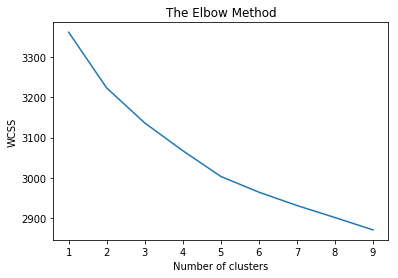

In [28]:
find_number_clusters(tfidf_matrix.todense())

Now, we cannot find a clear elbow here, but through trial and error, I have found out that the optimal value for K here is **5**. Now, that we have found the value for K, lets go ahead and run the K means model on the data. We will use the function defined below. 

In [82]:
def apply_kmeans(num_clusters,random_state,tfidf):
    km = KMeans(n_clusters=num_clusters, random_state =random_state)
    km.fit(tfidf)
    clusters = km.labels_.tolist()
    return km,clusters

In [133]:
# Apply Kmeans Clustering
km, clusters = apply_kmeans(num_clusters=5,random_state=42,tfidf= tfidf_matrix)

The *apply_kmeans* function is again pretty straightforward, we are running it on the tfidf matrix, we select the value for k as 5, and we include a random state parameter, so we will always get the same clusters if we run the notebook over and over again. 

In [52]:
# saving the clustering model
from sklearn.externals import joblib

#uncomment the below to save your model 
#joblib.dump(km,  '5clusters.pkl')
#since I've already run my model I am loading from the pickle
#Uncomment to load the model with 5 clusters
num_clusters = 5
km = joblib.load('5clusters.pkl')
clusters = km.labels_.tolist()

We use joblib.dump to pickle the model, after it has converged and to reload the model/reassign the labels as the clusters.

Now, we need to perform some steps to visualize these clusters. Basically we need to see what companies are associated with what cluster numbers as decided by the K means algorithm. 

First, we will create a dataframe called df_corpus that contains the ticker of each company along with the cluster number associated with it. Since we had chosen the K value as 5, cluster numbers will be from 0 to 4. See the first 5 rows of the dataframe below..

In [53]:
# Creating a dataframe that contains the company ticker along with the cluster number
df_corpus = pd.DataFrame({'Ticker':corpus.fileids(), 'Clusters':clusters})
df_corpus.head(5)

,Clusters,Ticker
0,3,A-profile.txt
1,3,AA-profile.txt
2,3,AAC-profile.txt
3,3,AAL-profile.txt
4,3,AAMC-profile.txt


Ok, let's leave df_corpus as it is for now. Remember, I had mentioned at the beginning that there also is a .csv file containing a referenced list of stock tickers and basic company information. Lets read that information into a dataframe, lets call that df. 

In [83]:
# creating a dataframe which contains additional information about each company
df = pd.read_csv("C:\\Users\\Mr. Priyan\\Dropbox\\Data Science\\DDL\\company_info.csv")
df.head(5)

,Ticker,Company,Sector,Industry,Country
0,A,"Agilent Technologies, Inc.",Healthcare,Medical Laboratories & Research,USA
1,AA,Alcoa Inc.,Basic Materials,Aluminum,USA
2,AAAP,Advanced Accelerator Applications S.A.,Healthcare,Diagnostic Substances,France
3,AAC,"AAC Holdings, Inc.",Healthcare,Specialized Health Services,USA
4,AADR,AdvisorShares WCM/BNY MlnFcsd GR ADR ETF,Financial,Exchange Traded Fund,USA


Seems interesting, now if we look at both df_corpus and df, we can see that both of them contains the same Ticker column, except the Ticker column in df_corpus has '-profile.txt' at the end of it. Now, if we can remove that bit, then both the Ticker columns in both the dataframes would be exactly the same. If that happened, then we can merge the 2 dataframes together by performing an inner join on the Ticker column. Let's do that! 

In [55]:
# Removing the "-profile.txt" from the Ticker
import re
for i in range(0,len(df_corpus)):
    df_corpus.loc[i,'Ticker']=re.sub("-profile.txt","",df_corpus.loc[i,'Ticker'])
df_corpus.head(5)

,Clusters,Ticker
0,3,A
1,3,AA
2,3,AAC
3,3,AAL
4,3,AAMC


Voila! '-profile.txt' has been removed using regex.

In [56]:
# merging the two dataframe on the Ticker
merged_df = pd.merge(left=df, right=df_corpus, how='inner', on="Ticker")

In [84]:
merged_df.sample(5)

,Ticker,Company,Sector,Industry,Country,Clusters
2809,SBH,Sally Beauty Holdings Inc.,Services,"Specialty Retail, Other",USA,3
68,AE,Adams Resources & Energy Inc.,Basic Materials,Oil & Gas Refining & Marketing,USA,4
2978,SRCL,"Stericycle, Inc.",Industrial Goods,Waste Management,USA,3
2721,RMT,"Royce Micro-Cap Trust, Inc.",Financial,Closed-End Fund - Equity,USA,1
1158,EXEL,"Exelixis, Inc.",Healthcare,Biotechnology,USA,0


The dataframes have been merged and we have called the resulting dataframe as merged_df. We can now see additional information about a company including its Sector, Industry and the Country it is based in. Remember, our clustering algorithm grouped the companies only based on its description.

### Top Topics Per Cluster

Moving on to the most interesting part, find out the top topics/terms of each cluster. The function below does just that. Basically, a special indexing, sorting is performed on each cluster and the top terms closest to the cluster centroid will be printed. Let me explain the parameters to the function. 

- df : The merged_df we got earlier will be passed here. merged_df contains the cluster numbers and the company names we need to display. 
- km: This is the object of the K means clustering algorithm we had performed earlier. We can extract the cluster centers from this. 
- num_clusters : This is the value of K chosen for the K means algorithm, which is 5. 
- num_cluster_topics : This decides the number for the top terms of the cluster to be displayed. I chose 5. 
- num_cluster_companies : This decides how many random companies of each cluster will be displayed. I chose 5 again.  


In [3]:
def print_cluster(df, km, num_clusters, cluster_level, num_cluster_topics=3, num_cluster_companies=2) :
    
    print("Top terms per cluster:")
    print()
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
    for i in range(num_clusters):
        print("Cluster %d words:" % int(i), end='')

        for ind in range(0,num_cluster_topics): # top 6 words per cluster
            print(' %s' % unstem(terms[order_centroids[i,ind]]), end=',')
        print() #add whitespace
        print() #add whitespace

        print("Cluster %d Companies:" % int(i), end='')
        #print()
        for title in df[df[cluster_level]==i]["Company"].sample(num_cluster_companies).values.tolist():
            print(' %s,' % title, end='')
            #uncomment below to see the Sector and Industry of each Company
            #print("Sector:",merged_df.Sector[merged_df.Company==title].values[0],"Industry:",merged_df.Industry[merged_df.Company==title].values[0])
        print() #add whitespace
        print() #add whitespace

    print("Split of classes within clusters:")
    print(df[cluster_level].value_counts())
    

In [89]:
# Printing terms per cluster
print_cluster(df=merged_df, km=km, num_clusters=5, num_cluster_topics=5, \
              num_cluster_companies=5, cluster_level='Clusters')

Top terms per cluster:

Cluster 0 words: treatment, clinic, developing, phase, disease,

Cluster 0 Companies: Bio Blast Pharma Ltd., SCYNEXIS, Inc., NewLink Genetics Corporation, GlycoMimetics, Inc., Atossa Genetics, Inc.,

Cluster 1 words: investment, fund, real estate, estate, real,

Cluster 1 Companies: Retail Properties of America, Inc., American Campus Communities, Inc., Cornerstone Strategic Value Fund, Inc., Annaly Capital Management, Inc., Waddell & Reed Financial, Inc.,

Cluster 2 words: loans, banks, deposit, accounts, credit,

Cluster 2 Companies: IberiaBank Corp., Sussex Bancorp, S&T Bancorp Inc., Norwood Financial Corp., BankFinancial Corp.,

Cluster 3 words: retailing, application, technologies, equipment, designs,

Cluster 3 Companies: Universal Technical Institute, Inc., Marinemax Inc., Autodesk, Inc., xG Technology, Inc., Air Transport Services Group, Inc.,

Cluster 4 words: gas, oil, natural gas, natural, energy,

Cluster 4 Companies: W&T Offshore Inc., RSP Permian, I

**Now, we see some interesting results.** 

From a quick look at the topics and company names, cluster 0 seems like it contains mostly companies related to the Healthcare industry.

Cluster 1 seems like it contains companies related to real estate or investment. 

Cluster 2 seems like it contains companies in the Financial industry. 

Cluster 3 has companies dealing with a broad range of industries such as Retail, Technology, Application, Equipment. 

Cluster 4 seems to have companies that deal mostly involved in the energy industry. 

Also, look at the the number of companies within each cluster. We know that there are a total of 3558 companies, now out of this cluster 3 contains 2197 companies, which are a majority of the companies! It seems obvious that we will have to break this cluster into more sub clusters. Now, we need to figure out which of the other clusters needs to be broken down further.

For this I will look at the most reccuring Sector for each cluster by looking at the merged_df dataframe.



In [88]:
# Printing the most recurring Sector(taken from previous dataframe) in each cluster
for i in range(num_clusters):
    print("Cluster",i,":",merged_df[merged_df.Clusters==i].Sector.mode()[0],":- % correct categories is ", \
    round(len(merged_df[merged_df.Clusters==i][merged_df[merged_df.Clusters==i].Sector==\
    merged_df[merged_df.Clusters==i].Sector.mode()[0]])/len(merged_df[merged_df.Clusters==i])*100,2))   

Cluster 0 : Healthcare :- % correct categories is  98.8
Cluster 1 : Financial :- % correct categories is  95.0
Cluster 2 : Financial :- % correct categories is  99.2
Cluster 3 : Services :- % correct categories is  25.94
Cluster 4 : Basic Materials :- % correct categories is  68.84


It seems that almost 100% of Cluster 0 and Cluster 2 contain companies belonging to one industry;Healthcare and Financial respectively. Which confirms the guess we made earlier. So, we don't need to break these clusters down further. Using the same logic, Cluster 3 and 4 certainly need to be broken down. The decision to break down Cluster 1 isn't that clear, here it looks like 95% of companies belong to the Financial Sector, but based on the topics we looked at earlier, companies are either related to the real estate or investment industry. Since, we are still not clear, lets break this cluster down further. 

Before we proceed, I also want to save the top terms related to each cluster in a dictionary. The function below does just that. There is a parameter called num_cluster_topics where one can specify the top N topics to be saved, default value is 10. The key of the dictionary will be the cluster number and the value contains a list of the topics. 

In [92]:
def save_topics(df, km, num_clusters, cluster_level, num_cluster_topics=10) :
    
    if cluster_level=='Clusters':
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            for ind in range(0,num_cluster_topics):                    
                topics_list.append(unstem(terms[order_centroids[i,ind]]))        
            topics_dict.update({str(i):topics_list})    
        return topics_dict
    
    if cluster_level=='Subclusters_level_1':
        level1= df['Clusters'].unique()[0]
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            for ind in range(0,num_cluster_topics):                    
                topics_list.append(unstem(terms[order_centroids[i,ind]]))        
            
            topics_dict.update({str(level1)+str(i):topics_list})
        return topics_dict
    
    if cluster_level=='Subclusters_level_2':
        level1= int(df['Clusters'].unique()[0])
        level2 =int(df['Subclusters_level_1'].unique()[0]) 
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            for ind in range(0,num_cluster_topics):                    
                topics_list.append(unstem(terms[order_centroids[i,ind]]))        
            
            topics_dict.update({str(level1)+str(level2)+str(i):topics_list})
        return topics_dict    
        

In [90]:
# save cluster topics into a dictionary
topics = save_topics(df=df, km=km, num_clusters=num_clusters, cluster_level='Clusters', num_cluster_topics=10)

# Creating Sub Clusters - Level 1 :Splitting clusters 1,3 & 4 into sub-clusters<a name="clustering level 1"></a>

We will be creating the subclusters now. Lets split Cluster 1 [investment, fund, real estate] first. We will again apply K means on the tfidf matrix consisting of companies belonging only to this cluster and then print out the top topics of the subclusters. 

### Splitting cluster 1


execution time: 0.04 minutes


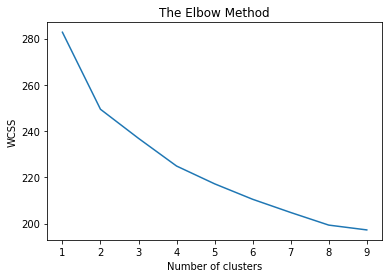

In [33]:
find_number_clusters(cluster1_tfidif.todense())

We again used the elbow method to find the optimal value of K. I have chosen it to be 2 empirically. Below, we will display the top terms belonging to each subcluster. 

In [230]:
# trying to find subclusters for any cluster 
Subcluster1_df=merged_df[merged_df['Clusters']==1]
# to get only the indices for this cluster
cluster1_tfidif=tfidf_matrix[Subcluster1_df.index.values]
km,clusters = apply_kmeans(num_clusters = 2,random_state =10,tfidf = cluster1_tfidif)
# add new column which includes the numbers of the new clusters
Subcluster1_df = Subcluster1_df.assign(Subclusters_level_1 = clusters)
# Printing terms per cluster
print_cluster(df=Subcluster1_df, km=km, num_clusters=2, num_cluster_topics=6, \
             num_cluster_companies=5, cluster_level='Subclusters_level_1')

Top terms per cluster:

Cluster 0 words: real estate, investment, estate, properties, real, trust,

Cluster 0 Companies: Retail Properties of America, Inc., Lexington Realty Trust, JW Mays Inc., America First Multifamily Investors, L.P., Alexander's Inc.,

Cluster 1 words: investment, fund, equity, income, stock, indexes,

Cluster 1 Companies: Franklin Resources, Inc., Capital Southwest Corporation, OFG Bancorp, Piper Jaffray Companies, Saratoga Investment Corp.,

Split of classes within clusters:
0    215
1    145
Name: Subclusters_level_1, dtype: int64


We see that cluster1 with topics (investment, fund, real estate) got split into 2 subclusters: subcluster 0 mostly related to properties and real estate, and subcluster 1 mostly related to investment, equity, stock which suggest that it contains companies mostly related to asset management and investment. 

Although, the term investment seems to appear in both subclusters. Ideally we don't want most of the topics of the parent cluster to be included in the child cluster, we want to find out more unique topics. One way to fix this would be to remove some of the most occuring topics of the parent cluster and prevent them from showing up in the child clusters.
The *freq_words* function below gives the most frequently occuring words/terms of a particular parent cluster.The parameters of the function are:
- the index values of the companies(in the dataframe)belonging to the particular parent cluster
- the new_corpus list
- the terms variable containing all 735 features/terms selected by the tfidf vectorizer
- variable X that decides the number of most occuring topics to remove. 


In [7]:
def freq_words(indexes,new_corpus,terms,X):
    cluster_descriptions=""
    for i in (indexes):
        cluster_descriptions = cluster_descriptions+new_corpus[i]+" "
    cluster_descriptions=cluster_descriptions[:-1]
    from collections import Counter
    Counter = Counter(cluster_descriptions.split())
    #freq_words has most commonly occuring words within parent cluster ranked in descending order
    freq_words=Counter.most_common()
    # freq_terms has most commonly occuring terms(from tfidf matrix) within parent cluster ranked in descending order along with 
    #frequencies
    freq_terms_with_count = []
    for word in freq_words:
        if word[0] in set(terms):
            freq_terms_with_count.append(word)
    #sorted list of most occuring terms in cluster 3 , subcluster 1
    freq_terms = []
    for i in range(len(freq_terms_with_count)):
        freq_terms.append(freq_terms_with_count[i][0])
    # top X most occuring terms from that cluster
    # here is where you can play around with the X value
    X_freq_terms=freq_terms[0:X]
    return X_freq_terms, freq_terms_with_count   

In [240]:
X_freq_terms, freq_terms_with_count = freq_words(indexes=Subcluster1_df.index.values,new_corpus=new_corpus,\
                                                terms=terms,X=2)

The *freq_words* function is called above and through trial and error I had chosen the value of X as 2. You can see the most commonly occuring terms of subcluster 1 below along with the count. 

In [241]:
freq_terms_with_count

[('invest', 1258),
 ('fund', 567),
 ('real', 492),
 ('estat', 479),
 ('equiti', 369),
 ('properti', 352),
 ('trust', 303),
 ('incom', 297),
 ('secur', 290),
 ('portfolio', 251),
 ('mortgag', 249),
 ('million', 231),
 ('manag', 230),
 ('asset', 221),
 ('loan', 215),
 ('capit', 195),
 ('stock', 160),
 ('financi', 159),
 ('develop', 156),
 ('primarili', 152),
 ('reit', 150),
 ('index', 139),
 ('york', 138),
 ('debt', 136),
 ('financ', 136),
 ('seek', 130),
 ('residenti', 124),
 ('fix', 124),
 ('institut', 121),
 ('investor', 115),
 ('addit', 113),
 ('base', 113),
 ('trade', 113),
 ('relat', 112),
 ('mutual', 112),
 ('tax', 109),
 ('offic', 107),
 ('oper', 107),
 ('retail', 103),
 ('focus', 103),
 ('leas', 102),
 ('inform', 100),
 ('insur', 99),
 ('valu', 94),
 ('growth', 90),
 ('distribut', 89),
 ('hotel', 88),
 ('llc', 85),
 ('www', 84),
 ('client', 81),
 ('high', 78),
 ('launch', 78),
 ('diversifi', 76),
 ('advisori', 76),
 ('end', 76),
 ('acquisit', 74),
 ('non', 74),
 ('term', 73),
 (

We can see that the word invest(please note all these words are the stemmed words) is occuring most often(1258 when compared to all other words in the 100's), followed by the word fund. If we remove these words from the topics of the subclusters, their topics will make more sense. If we need to do that, then we need to modify the *print_cluster* function a little bit. For that reason, the *print_cluster_words* function is defined below.The working of the function is quite similar to the *print_cluster function* except it does not print out the X most occuring terms of the parent cluster.  

In [242]:
def print_cluster_words(df, km, num_clusters, cluster_level, words, num_cluster_topics=3, num_cluster_companies=2) :
    
    print("Top terms per cluster:")
    print()
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
    for i in range(num_clusters):
        print("Cluster %d words:" % int(i), end='')        
        flag=0
        ind=0
        while flag < num_cluster_topics: # top n words per cluster
            check_word = terms[order_centroids[i,ind]]
            check_word = check_word.split(' ')
            
            
            if len(set(check_word).intersection(words))==0:
                print(' %s' % unstem(' '.join(check_word)), end=',')
                flag=flag+1
                ind = ind+1
            else:
                ind = ind+1
                    
        print() #add whitespace
        print() #add whitespace

        print("Cluster %d Companies:" % int(i), end='')
        #print()
        for title in df[df[cluster_level]==i]["Company"].sample(num_cluster_companies).values.tolist():
            print(' %s,' % title, end='')
            #uncomment below to see the Sector and Industry of each Company
            #print("Sector:",merged_df.Sector[merged_df.Company==title].values[0],"Industry:",merged_df.Industry[merged_df.Company==title].values[0])
        print() #add whitespace
        print() #add whitespace

    print("Split of classes within clusters:")
    print(df[cluster_level].value_counts())
    

In [243]:
print_cluster_words(df=Subcluster1_df, km=km, num_clusters=2, cluster_level='Subclusters_level_1',\
                    words=X_freq_terms , num_cluster_topics=3, num_cluster_companies=3)

Top terms per cluster:

Cluster 0 words: real estate, estate, properties,

Cluster 0 Companies: Diamondrock Hospitality Co., VEREIT, Inc., LTC Properties Inc.,

Cluster 1 words: equity, income, stock,

Cluster 1 Companies: Source Capital, Inc., Silvercrest Asset Management Group Inc., Federated Investors, Inc.,

Split of classes within clusters:
0    215
1    145
Name: Subclusters_level_1, dtype: int64


Great! Now the topics of the subclusters are more intuitive now. Our next step is decide when we need to stop splitting subclusters. The **stopping criteria** I have defined is we will only split when the topics are not intuitive enough or when the number of companies within a subcluster is more than 400. 400 is a little more than 10% of all the companies (3558). This seemed like a good number based on our current dataset. 

Now, with that logic, we will not split the subclusters of cluster 1 into more subclusters. At this point, I should also explain the numbering conventions of clusters/subclusters. Using our current example the parent cluster is 1, the subcluster 0 will then be number 10. If this subcluster were to be split into more subclusters(say 0,1) then those subclusters would be named 100 and 101. This logic continues when we split into further levels.

We, also need to save the topics of these subclusters. Since, we had removed the top terms from the parent cluster, we need to use a slightly modified function(*save_topics_words*) to save the topics. I invite you to understand the working of this function but please note that it is very similar to the original *save_topics* function with a few modifications based on the *print_cluster_words* function. The key of the dictionary follows the same naming convention I had explained above. 

In [244]:
def save_topics_words(df, km, num_clusters, cluster_level, words, num_cluster_topics=10) :
    
    if cluster_level=='Clusters':
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            flag=0
            ind=0
            while flag<num_cluster_topics:
                check_word = terms[order_centroids[i,ind]]
                check_word = check_word.split(' ')            
                if len(set(check_word).intersection(words))==0:
                    topics_list.append(unstem(' '.join(check_word)))
                    flag = flag + 1
                    ind = ind + 1
                else:
                    ind = ind + 1
            topics_dict.update({str(i):topics_list})    
        return topics_dict
    
    if cluster_level=='Subclusters_level_1':
        level1= df['Clusters'].unique()[0]
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            flag = 0
            ind = 0
            while flag<num_cluster_topics:                    
                check_word = terms[order_centroids[i,ind]]
                check_word = check_word.split(' ')            
                if len(set(check_word).intersection(words))==0:
                    topics_list.append(unstem(' '.join(check_word)))
                    flag = flag + 1
                    ind = ind + 1
                else:
                    ind = ind + 1
            
            topics_dict.update({str(level1)+str(i):topics_list})
        return topics_dict
    
    if cluster_level=='Subclusters_level_2':
        level1= int(df['Clusters'].unique()[0])
        level2 =int(df['Subclusters_level_1'].unique()[0]) 
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            flag = 0
            ind = 0
            while flag<num_cluster_topics:
                check_word = terms[order_centroids[i,ind]]
                check_word = check_word.split(' ')            
                if len(set(check_word).intersection(words))==0:
                    topics_list.append(unstem(' '.join(check_word)))
                    flag = flag + 1
                    ind = ind + 1
                else:
                    ind = ind + 1
            
            topics_dict.update({str(level1)+str(level2)+str(i):topics_list})
        return topics_dict
    
    if cluster_level=='Subclusters_level_3':
        level1= int(df['Clusters'].unique()[0])
        level2 =int(df['Subclusters_level_1'].unique()[0])
        level3 =int(df['Subclusters_level_2'].unique()[0])
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            flag = 0
            ind = 0
            while flag<num_cluster_topics:
                check_word = terms[order_centroids[i,ind]]
                check_word = check_word.split(' ')            
                if len(set(check_word).intersection(words))==0:
                    topics_list.append(unstem(' '.join(check_word))) 
                    flag = flag + 1
                    ind = ind + 1
                else:
                    ind = ind + 1
            
            topics_dict.update({str(level1)+str(level2)+str(level3)+str(i):topics_list})
        return topics_dict
    
    
        

In [245]:
# saving cluster topics into a dictionary
topics.update(save_topics_words(df=Subcluster1_df, km=km, num_clusters=2, cluster_level='Subclusters_level_1', words=X_freq_terms, num_cluster_topics=10))

You can have a look at the topics dictionary now and confirm how the key and values look. 

In [246]:
topics

{'0': ['treatment',
  'clinic',
  'developing',
  'phase',
  'disease',
  'trial',
  'therapeutics',
  'pharmaceutical',
  'cancer',
  'clinic trial'],
 '1': ['investment',
  'fund',
  'real estate',
  'estate',
  'real',
  'properties',
  'trust',
  'income',
  'equity',
  'real estate investment'],
 '10': ['real estate',
  'estate',
  'properties',
  'real',
  'trust',
  'reit',
  'mortgage',
  'www',
  'income',
  'hotel'],
 '11': ['equity',
  'income',
  'stock',
  'indexes',
  'seeking',
  'managing',
  'mutual',
  'capital',
  'fixed income',
  'secured'],
 '2': ['loans',
  'banks',
  'deposit',
  'accounts',
  'credit',
  'estate',
  'mortgage',
  'real estate',
  'financial',
  'real'],
 '3': ['retailing',
  'application',
  'technologies',
  'equipment',
  'designs',
  'network',
  'based',
  'software',
  'various',
  'distribution'],
 '30': ['software',
  'data',
  'network',
  'digital',
  'technologies',
  'application',
  'cloud',
  'mobile',
  'platform',
  'communities'

I am also storing the topics that I had removed from the parent cluster in a dictionary. I feel that it may be useful to keep this information. 

In [247]:
#saving removed topics into a dictionary
removed_topics = {}
removed_topics.update({'1':[unstem(word) for word in X_freq_terms]})

### Splitting the biggest cluster , cluster 3

Now, we will follow similar methodology and split Cluster 3[Retail, Application, Technology, Equipment]

execution time: 0.46 minutes


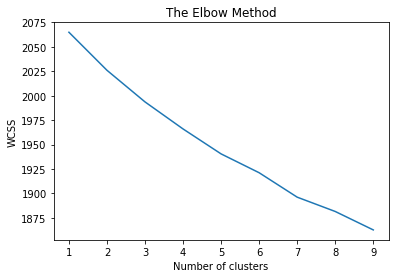

In [248]:
find_number_clusters(cluster3_tfidif.todense())

Using the elbow method, the optimal value of K was selected to be 4. The topics of the subclusters are printed below. 

In [249]:
# trying to find subclusters for any cluster 
Subcluster3_df=merged_df[merged_df['Clusters']==3]
# to get only the indices for this cluster
cluster3_tfidif=tfidf_matrix[Subcluster3_df.index.values]
km,clusters = apply_kmeans(num_clusters = 4,random_state =10,tfidf = cluster3_tfidif)
# add new column which includes the numbers of the new clusters
Subcluster3_df = Subcluster3_df.assign(Subclusters_level_1 = clusters)
# Printing terms per cluster
print_cluster(df=Subcluster3_df, km=km, num_clusters=4, num_cluster_topics=6, \
              num_cluster_companies=5, cluster_level='Subclusters_level_1')

Top terms per cluster:

Cluster 0 words: software, data, network, digital, technologies, application,

Cluster 0 Companies: Take-Two Interactive Software Inc., ScanSource, Inc., Paycom Software, Inc., Brightcove Inc., Professional Diversity Network, Inc.,

Cluster 1 words: equipment, power, components, engineering, application, testing,

Cluster 1 Companies: Waters Corporation, Neogenomics Inc., Benchmark Electronics Inc., Steel Dynamics Inc., Intricon Corp.,

Cluster 2 words: retailing, food, restaurants, home, care, accessories,

Cluster 2 Companies: Helmerich & Payne, Inc., JAKKS Pacific, Inc., Gevo, Inc., Ross Stores Inc., Regis Corp.,

Cluster 3 words: insurance, life, properties, casualty, properties casualty, life insurance,

Cluster 3 Companies: Horace Mann Educators Corp., Rush Enterprises, Inc., CoBiz Financial Inc., State Auto Financial Corp., Security National Financial Corp.,

Split of classes within clusters:
2    844
1    706
0    555
3     92
Name: Subclusters_level_1, 

The parent cluster no. 3 has split into some interesting subclusters as you can see from their topics. Based on the stopping criteria I had mentioned earlier, subcluster 0, 1 & 2 will be broken down further into subclusters, whereas subcluster 3 will not. The topics of these clusters are saved into the topics dictionary below.. 

In [250]:
# saving cluster topics into dictionary
topics.update(save_topics(df=Subcluster3_df, km=km, num_clusters=4, cluster_level='Subclusters_level_1', num_cluster_topics=10))

### Splitting cluster 4


Splitting Cluster 4[Oil, Natural Gas, Energy]

execution time: 0.12 minutes


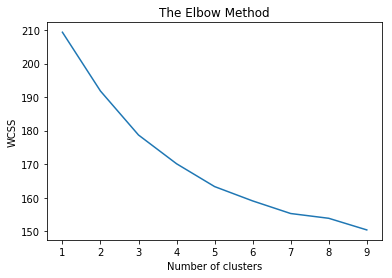

In [184]:
find_number_clusters(tfidf=cluster4_tfidif)

Using the elbow method, the optimal value of K was selected to be 2. The topics of the subclusters are printed below. 

In [252]:
Subcluster4_df=merged_df[merged_df['Clusters']==4]
# to get only the indices for this cluster
cluster4_tfidif=tfidf_matrix[Subcluster4_df.index.values]
km,clusters = apply_kmeans(num_clusters = 2,random_state =10,tfidf = cluster4_tfidif)
# add new column which includes the numbers of the new clusters
Subcluster4_df = Subcluster4_df.assign(Subclusters_level_1 = clusters)
# Printing terms per cluster
print_cluster(df=Subcluster4_df, km=km, num_clusters=2, num_cluster_topics=5, \
              num_cluster_companies=5, cluster_level='Subclusters_level_1')


Top terms per cluster:

Cluster 0 words: gas, natural gas, natural, electrical, pipelines,

Cluster 0 Companies: WEC Energy Group, Inc., NextEra Energy Partners, LP, Cheniere Energy Partners LP Holdings, LLC, National Fuel Gas Company, Northwestern Corporation,

Cluster 1 words: oil, gas, natural gas, natural, oil natural gas,

Cluster 1 Companies: Range Resources Corporation, PEDEVCO Corp., United States Lime & Minerals, Inc., MV Oil Trust, Colfax Corporation,

Split of classes within clusters:
1    155
0    137
Name: Subclusters_level_1, dtype: int64


We can see that the topics of these subclusters keep repeating the words natural gas and oil. So, we need to clear them out to find out more detailed unique topics. So lets use the *freq_words* function and the *print_cluster_words* function to remove some of the most occuring topics of the parent cluster and prevent them from showing up in the child clusters. I had empirically determined the value of X to be 4. See the topics of the subclusters after this is done below..

In [254]:
X_freq_terms, freq_terms_with_count = freq_words(indexes=Subcluster4_df.index.values,new_corpus=new_corpus,\
                                                 terms=terms,X=4)
print_cluster_words(df=Subcluster4_df, km=km, num_clusters=2, cluster_level='Subclusters_level_1',\
                    words=X_freq_terms , num_cluster_topics=5, num_cluster_companies=3)

Top terms per cluster:

Cluster 0 words: electrical, pipelines, mile, crude, storage,

Cluster 0 Companies: Quanta Services, Inc., EQT Corporation, Loews Corporation,

Cluster 1 words: exploration, basin, reserves, net, barrels,

Cluster 1 Companies: Marathon Oil Corporation, Oasis Petroleum Inc., Independence Contract Drilling, Inc.,

Split of classes within clusters:
1    155
0    137
Name: Subclusters_level_1, dtype: int64


Much better, we get unique topics now, also we won't be splitting the subclusters down further based on the stopping criteria. Saving the topics into the dictionary and storing the removed topics as well.. 

In [255]:
# saving cluster topics into dictionary
topics.update(save_topics_words(df=Subcluster4_df, km=km, num_clusters=2, cluster_level='Subclusters_level_1', words =X_freq_terms, num_cluster_topics=10))

In [222]:
#saving removed topics into a dictionary
removed_topics.update({'4':[unstem(word) for word in X_freq_terms]})

Since, we are done with the current level, we need to update the merged_df dataframe with the subclusters..The code is below..

In [257]:
#Combining Subclusters and adding into original dataframe
test=pd.concat([Subcluster1_df,Subcluster4_df,Subcluster3_df])
test.drop(['Country','Company','Sector','Industry','Clusters'], axis=1, inplace=True)
merged_df = pd.merge(left=merged_df, right=test, how='left', on="Ticker")

## Creating Sub Clusters - Level 2 <a name="clustering level 2"></a>

Lets, go to the next level of clusters. As, mentioned before we will be splitting Cluster 3, Subclusters 0, 1 & 2. So let's get going!

### Splitting cluster 3, subcluster 0 into more clusters

Splitting Cluster 3, subcluster 0 [software, data, network, digital]. Optimal value of K was found to be 4 from the elbow method below. After that, the topics of the subclusters are printed below. 

execution time: 0.08 minutes


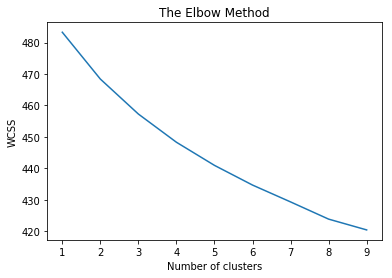

In [47]:
find_number_clusters(Subcluster3_level1_0_tfidif.todense())

In [258]:
# trying to find subclusters for any cluster 
Subcluster3_level1_0_df = merged_df[(merged_df['Clusters']==3) & (merged_df['Subclusters_level_1']==0)]
# to get only the indices for this cluster
Subcluster3_level1_0_tfidif=tfidf_matrix[Subcluster3_level1_0_df.index.values]
km,clusters = apply_kmeans(num_clusters = 4,random_state =42,tfidf = Subcluster3_level1_0_tfidif)
# add new column which includes the numbers of the new clusters
Subcluster3_level1_0_df = Subcluster3_level1_0_df.assign(Subclusters_level_2 = clusters)
# Printing terms per cluster
print_cluster(df=Subcluster3_level1_0_df, km=km, num_clusters=4, num_cluster_topics=5, \
              num_cluster_companies=5, cluster_level='Subclusters_level_2')

Top terms per cluster:

Cluster 0 words: payment, technologies, financial, information, online,

Cluster 0 Companies: Allscripts Healthcare Solutions, Inc., GlobalSCAPE, Inc., TrueCar, Inc., Medical Transcription Billing, Corp., Cambium Learning Group, Inc.,

Cluster 1 words: wireless, communities, network, video, voice,

Cluster 1 Companies: Universal Electronics Inc., Zayo Group Holdings, Inc., VOXX International Corporation, CenturyLink, Inc., Identiv, Inc.,

Cluster 2 words: software, data, cloud, application, enterprise,

Cluster 2 Companies: PTC Inc., Pure Storage, Inc., Teradata Corporation, QTS Realty Trust, Inc., Qualys, Inc.,

Cluster 3 words: digital, content, advertising, media, television,

Cluster 3 Companies: MeetMe, Inc., j2 Global, Inc., Time Warner Inc., Vuzix Corporation, Stratasys Ltd.,

Split of classes within clusters:
2    170
0    153
1    119
3    113
Name: Subclusters_level_2, dtype: int64


From the topics shown above, we can see that this general subcluster has split into some well defined subclusters now. We, will not need to split any of these subclusters since the total number of companies in each of them are less than 400, which is our stopping criteria. Saving the topics into the dictionary below. 

In [259]:
# saving cluster topics into dictionary
topics.update(save_topics(df=Subcluster3_level1_0_df, km=km, num_clusters=4, cluster_level='Subclusters_level_2', num_cluster_topics=10))

### Splitting cluster 3, subcluster 1 into more clusters

Splitting Cluster 3, subcluster 1 [equipment, power, components]. Optimal value of K was found to be 3 from the elbow method below. After that, the topics of the subclusters are printed below. 

execution time: 0.1 minutes


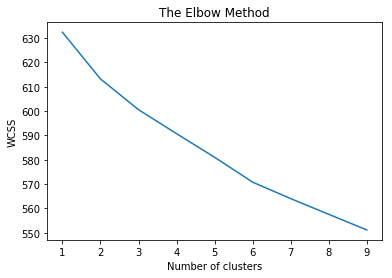

In [50]:
find_number_clusters(Subcluster3_level1_1_tfidif.todense())

In [260]:
Subcluster3_level1_1_df=merged_df[(merged_df['Clusters']==3) & (merged_df['Subclusters_level_1']==1)]
Subcluster3_level1_1_tfidif=tfidf_matrix[Subcluster3_level1_1_df.index.values]
km,clusters = apply_kmeans(num_clusters = 3,random_state =42,tfidf = Subcluster3_level1_1_tfidif)
# add new column which includes the numbers of the new clusters
Subcluster3_level1_1_df = Subcluster3_level1_1_df.assign(Subclusters_level_2 = clusters)
# Printing terms per cluster
print_cluster(df=Subcluster3_level1_1_df, km=km, num_clusters=3, num_cluster_topics=5, \
              num_cluster_companies=3, cluster_level='Subclusters_level_2')
#removing X most frequent terms from parent cluster

Top terms per cluster:

Cluster 0 words: medical, testing, diagnostics, surgical, devices,

Cluster 0 Companies: Sensus Healthcare, Inc., Edwards Lifesciences Corp., Strata Skin Sciences, Inc.,

Cluster 1 words: electronic, semiconductor, testing, equipment, devices,

Cluster 1 Companies: Micron Technology, Inc., HEICO Corporation, Sparton Corp.,

Cluster 2 words: equipment, power, engineering, components, construction,

Cluster 2 Companies: Berry Plastics Group, Inc., Matthews International Corporation, Axalta Coating Systems Ltd.,

Split of classes within clusters:
2    386
1    166
0    154
Name: Subclusters_level_2, dtype: int64


It seems that the topics of the subclusters are not unique enough. So we will be using the *freq_words* and *print_cluster_words*, functions to extract more unique topics. The value of the X parameter in the *freq_words* function was empirically chosen as 10. Let's look at the topics now. 

In [261]:
X_freq_terms, freq_terms_with_count = freq_words(indexes=Subcluster3_level1_1_df.index.values,new_corpus=new_corpus,\
                                                 terms=terms,X=10)
print_cluster_words(df=Subcluster3_level1_1_df, km=km, num_clusters=3, cluster_level='Subclusters_level_2',\
                    words=X_freq_terms , num_cluster_topics=4, num_cluster_companies=2)

Top terms per cluster:

Cluster 0 words: medical, diagnostics, surgical, instruments,

Cluster 0 Companies: Vermillion, Inc., OpGen, Inc.,

Cluster 1 words: electronic, semiconductor, optical, aerospace,

Cluster 1 Companies: Power Integrations Inc., Ultralife Corp.,

Cluster 2 words: construction, materials, electrical, chemical,

Cluster 2 Companies: AeroVironment, Inc., BorgWarner Inc.,

Split of classes within clusters:
2    386
1    166
0    154
Name: Subclusters_level_2, dtype: int64


That certainly helped the topics are unique now and we have successfully split the subcluster to distinct categories. I will save the topics and removed topics into the respectively dictionaries. We will also not be splitting these subclusters any further.  

In [262]:
# saving cluster topics into dictionary
topics.update(save_topics_words(df=Subcluster3_level1_1_df, km=km, num_clusters=3, cluster_level='Subclusters_level_2', num_cluster_topics=10,words=X_freq_terms))

In [263]:
#saving removed topics into a dictionary
removed_topics.update({'31':[unstem(word) for word in X_freq_terms]})

### Splitting cluster 3, subcluster 2 into more clusters

Last subcluster in this level left to be split. It is Cluster 3 subcluster 2[retailing, food, restaurants, home]. The K value was chosen to be 3. 

execution time: 0.13 minutes


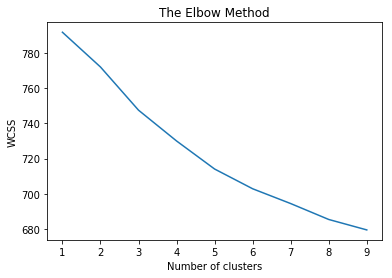

Top terms per cluster:

Cluster 0 words: food, care, retailing, home, health,

Cluster 0 Companies: Easterly Government Properties, Inc., Walgreens Boots Alliance, Inc., Radiant Logistics, Inc., Halyard Health, Inc., Entergy Texas, Inc.,

Cluster 1 words: accessories, apparel, retailing, women, home,

Cluster 1 Companies: Hooker Furniture Corp., Mattel, Inc., Destination Maternity Corporation, Unifi Inc., Christopher & Banks Corporation,

Cluster 2 words: restaurants, franchised, operational, december, food,

Cluster 2 Companies: Ark Restaurants Corp., The Wendy's Company, El Pollo Loco Holdings, Inc., Papa John's International Inc., Wingstop Inc.,

Split of classes within clusters:
0    663
1    137
2     44
Name: Subclusters_level_2, dtype: int64


In [264]:
Subcluster3_level1_2_df = merged_df[(merged_df['Clusters']==3) & (merged_df['Subclusters_level_1']==2)]
Subcluster3_level1_2_tfidif=tfidf_matrix[Subcluster3_level1_2_df.index.values]

find_number_clusters(Subcluster3_level1_2_tfidif.todense())
km,clusters = apply_kmeans(num_clusters = 3,random_state =42,tfidf = Subcluster3_level1_2_tfidif)
# add new column which includes the numbers of the new clusters
Subcluster3_level1_2_df = Subcluster3_level1_2_df.assign(Subclusters_level_2 = clusters)
# Printing terms per cluster
print_cluster(df=Subcluster3_level1_2_df, km=km, num_clusters=3, num_cluster_topics=5, \
              num_cluster_companies=5, cluster_level='Subclusters_level_2')

Alright, it would still be better if we removed some topics from the subclusters, and we selected the value of X in the *freq_words* function as 2. Lets look at the topics now.

In [265]:
X_freq_terms, freq_terms_with_count = freq_words(indexes=Subcluster3_level1_2_df.index.values,new_corpus=new_corpus,\
                                                 terms=terms,X=2)
print_cluster_words(df=Subcluster3_level1_2_df, km=km, num_clusters=3, cluster_level='Subclusters_level_2',\
                    words=X_freq_terms , num_cluster_topics=3, num_cluster_companies=3)

Top terms per cluster:

Cluster 0 words: food, care, health,

Cluster 0 Companies: Total System Services, Inc., Silgan Holdings Inc., Dr Pepper Snapple Group, Inc.,

Cluster 1 words: accessories, apparel, women,

Cluster 1 Companies: The Buckle, Inc., Sears Hometown and Outlet Stores, Inc., Harley-Davidson, Inc.,

Cluster 2 words: restaurants, franchised, operational,

Cluster 2 Companies: Zoe's Kitchen, Inc., Bloomin' Brands, Inc., Denny's Corporation,

Split of classes within clusters:
0    663
1    137
2     44
Name: Subclusters_level_2, dtype: int64


That helps! Also based on the stopping criteria Subcluster 0 will be split further but not the others. Saving the topics and the removed topics into the respectively dictionaries as usual!

In [266]:
# saving cluster topics into dictionary
topics.update(save_topics_words(df=Subcluster3_level1_2_df, km=km, num_clusters=3, cluster_level='Subclusters_level_2', num_cluster_topics=10,words=X_freq_terms))

In [267]:
#saving removed topics into a dictionary
removed_topics.update({'32':[unstem(word) for word in X_freq_terms]})

Since, we are done with the current level, we need to update the merged_df dataframe with the subclusters..The code is below..

In [268]:
test=pd.concat([Subcluster3_level1_1_df,Subcluster3_level1_2_df,Subcluster3_level1_0_df])
test.drop(['Country','Company','Sector','Industry','Clusters','Subclusters_level_1'], axis=1, inplace=True)
merged_df = pd.merge(left=merged_df, right=test, how='left', on="Ticker")

# Creating Sub Clusters - Level 3 <a name="clustering level 3"></a>

We move on to the next level. 

### Splitting cluster 3, subcluster 2, subcluster 0 into more clusters

We are splitting Cluster 3, subcluster 2, subcluster 0[food, care, health]. K value was chosen to be 4. And we chose the X value for the freq_words function as 2. See the topics below. 

execution time: 0.1 minutes


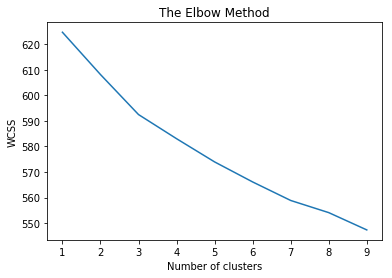

In [270]:
## splitting 3-2-0 into more clusters
Subcluster320_df = merged_df[(merged_df['Clusters']==3) & (merged_df['Subclusters_level_1']==2) & (merged_df['Subclusters_level_2']==0)]
Subcluster320_tfidif=tfidf_matrix[Subcluster320_df.index.values]

find_number_clusters(Subcluster320_tfidif.todense())


In [271]:
km,clusters = apply_kmeans(num_clusters = 4,random_state =42,tfidf = Subcluster320_tfidif)
# add new column which includes the numbers of the new clusters
Subcluster320_df = Subcluster320_df.assign(Subclusters_level_3 = clusters)
# Printing terms per cluster
#print_cluster(df=Subcluster3_level1_2_df, km=km, num_clusters=3, num_cluster_topics=5, \
#              num_cluster_companies=5, cluster_level='Subclusters_level_2')
#removing X most frequent terms from parent cluster
X_freq_terms, freq_terms_with_count = freq_words(indexes=Subcluster320_df.index.values,new_corpus=new_corpus,\
                                                 terms=terms,X=2)
print_cluster_words(df=Subcluster320_df, km=km, num_clusters=4, cluster_level='Subclusters_level_3',\
                    words=X_freq_terms , num_cluster_topics=5, num_cluster_companies=3)

Top terms per cluster:

Cluster 0 words: beverage, packaged, grocery, distributors, natural,

Cluster 0 Companies: Orchids Paper Products Company, WestRock Company, Rollins Inc.,

Cluster 1 words: care, health, medical, pharmacies, healthcare,

Cluster 1 Companies: Rite Aid Corporation, Care.com, Inc., LHC Group, Inc.,

Cluster 2 words: home, water, hotel, holdings, based,

Cluster 2 Companies: Sonic Corp., The Priceline Group Inc., Compass Minerals International Inc.,

Cluster 3 words: transportation, logistics, vehicles, trucks, fleet,

Cluster 3 Companies: CH Robinson Worldwide Inc., PACCAR Inc., AutoNation, Inc.,

Split of classes within clusters:
2    370
0    114
1     91
3     88
Name: Subclusters_level_3, dtype: int64


There we have it, we do not need to split any further. Lets save the topics and the removed topics. 

In [272]:
# saving cluster topics into dictionary
topics.update(save_topics_words(df=Subcluster320_df, km=km, num_clusters=4, cluster_level='Subclusters_level_3', num_cluster_topics=10,words=X_freq_terms))

In [273]:
removed_topics.update({'320':[unstem(word) for word in X_freq_terms]})

Lets update the merged_df dataframe.

In [277]:
test=pd.concat([Subcluster320_df])
test.drop(['Country','Company','Sector','Industry','Clusters','Subclusters_level_1', 'Subclusters_level_2'], axis=1, inplace=True)
merged_df = pd.merge(left=merged_df, right=test, how='left', on="Ticker")

 #check if new_merged_df is correct, if so then rename it to merged_df
merged_df.columns = ['Ticker', 'Company', 'Sector', 'Industry', 'Country', 'Clusters Level 0','Clusters Level 1', \
                         'Clusters Level 2', 'Clusters Level 3']

---

Now that we are done with splitting clusters. Lets look at the final dataframe. There are 4 levels of hierarchical clusters starting from 0 to 4. 

In [278]:
# See the dataframe with the 4 levels, level 0, level 1 and level 2 and level 3
merged_df

,Ticker,Company,Sector,Industry,Country,Clusters Level 0,Clusters Level 1,Clusters Level 2,Clusters Level 3
0,A,"Agilent Technologies, Inc.",Healthcare,Medical Laboratories & Research,USA,3,1.0,0.0,NaN
1,AA,Alcoa Inc.,Basic Materials,Aluminum,USA,3,2.0,0.0,0.0
2,AAC,"AAC Holdings, Inc.",Healthcare,Specialized Health Services,USA,3,2.0,0.0,1.0
3,AAL,American Airlines Group Inc.,Services,Major Airlines,USA,3,2.0,0.0,3.0
4,AAMC,Altisource Asset Management Corporation,Financial,Asset Management,USA,3,2.0,0.0,2.0
5,AAME,Atlantic American Corp.,Financial,Life Insurance,USA,3,3.0,NaN,NaN
6,AAN,"Aaron's, Inc.",Services,Rental & Leasing Services,USA,3,2.0,1.0,NaN
7,AAOI,"Applied Optoelectronics, Inc.",Technology,Semiconductor - Integrated Circuits,USA,3,1.0,1.0,NaN
8,AAON,AAON Inc.,Industrial Goods,General Building Materials,USA,3,1.0,2.0,NaN
9,AAP,Advance Auto Parts Inc.,Services,Auto Parts Stores,USA,3,1.0,2.0,NaN


We can't really understand much from this dataframe as the Clusters are numerical values, so we need to replace these values with the actual topics, and that is what we will be doing in the subsequent sessions. 

## dataframe showing the topics <a name='final result'></a>

In [279]:
# copy the dataframe to a new one (has its own values)
temp_df = merged_df.copy(deep=True)

We are writing code that takes replaces the numerical values of clusters with the actual topics into the dataframe. We are getting the topics from the topics dictionary.

In [280]:
## adding topics into the dataframe
temp_df['Clusters Level 0'] = temp_df['Clusters Level 0'].astype(object)
temp_df['Clusters Level 1'] = temp_df['Clusters Level 1'].astype(object)
temp_df['Clusters Level 2'] = temp_df['Clusters Level 2'].astype(object)
temp_df['Clusters Level 3'] = temp_df['Clusters Level 3'].astype(object)

for key in topics:
    if len(key)==4:
        l0=key[0]
        l1=key[1]
        l2=key[2]
        l3=key[3]
        test = temp_df[(temp_df['Clusters Level 0']==int(l0)) & (temp_df['Clusters Level 1']==int(l1)) & (temp_df['Clusters Level 2']==int(l2)) & (temp_df['Clusters Level 3']==int(l3))]                   
        for ind in test.index.values:
            temp_df.at[ind,'Clusters Level 3'] =topics[key]

for key in topics:    
    if len(key)==3:
        l0=key[0]
        l1=key[1]
        l2=key[2]
        
        test = temp_df[(temp_df['Clusters Level 0']==int(l0)) & (temp_df['Clusters Level 1']==int(l1)) & (temp_df['Clusters Level 2']==int(l2))]                   
        for ind in test.index.values:
            temp_df.at[ind,'Clusters Level 2'] =topics[key]
for key in topics:
    if len(key)==2:
        l0=key[0]
        l1=key[1]
               
        test = temp_df[(temp_df['Clusters Level 0']==int(l0)) & (temp_df['Clusters Level 1']==int(l1))]                   
        for ind in test.index.values:
            temp_df.at[ind,'Clusters Level 1'] =topics[key]
for key in topics:
    if len(key)==1:        
        test = temp_df[temp_df['Clusters Level 0']==int(key)]
        for i in test.index.values:
            temp_df.at[i,'Clusters Level 0'] = topics[key]


In [282]:
#Dataframe showing all hierarchical topics
merged_df = temp_df

In [284]:
merged_df

,Ticker,Company,Sector,Industry,Country,Clusters Level 0,Clusters Level 1,Clusters Level 2,Clusters Level 3
0,A,"Agilent Technologies, Inc.",Healthcare,Medical Laboratories & Research,USA,"[retailing, application, technologies, equipme...","[equipment, power, components, engineering, ap...","[medical, diagnostics, surgical, instruments, ...",NaN
1,AA,Alcoa Inc.,Basic Materials,Aluminum,USA,"[retailing, application, technologies, equipme...","[retailing, food, restaurants, home, care, acc...","[food, care, health, based, water, beverage, d...","[beverage, packaged, grocery, distributors, na..."
2,AAC,"AAC Holdings, Inc.",Healthcare,Specialized Health Services,USA,"[retailing, application, technologies, equipme...","[retailing, food, restaurants, home, care, acc...","[food, care, health, based, water, beverage, d...","[care, health, medical, pharmacies, healthcare..."
3,AAL,American Airlines Group Inc.,Services,Major Airlines,USA,"[retailing, application, technologies, equipme...","[retailing, food, restaurants, home, care, acc...","[food, care, health, based, water, beverage, d...","[transportation, logistics, vehicles, trucks, ..."
4,AAMC,Altisource Asset Management Corporation,Financial,Asset Management,USA,"[retailing, application, technologies, equipme...","[retailing, food, restaurants, home, care, acc...","[food, care, health, based, water, beverage, d...","[home, water, hotel, holdings, based, developi..."
5,AAME,Atlantic American Corp.,Financial,Life Insurance,USA,"[retailing, application, technologies, equipme...","[insurance, life, properties, casualty, proper...",NaN,NaN
6,AAN,"Aaron's, Inc.",Services,Rental & Leasing Services,USA,"[retailing, application, technologies, equipme...","[retailing, food, restaurants, home, care, acc...","[accessories, apparel, women, merchandisers, s...",NaN
7,AAOI,"Applied Optoelectronics, Inc.",Technology,Semiconductor - Integrated Circuits,USA,"[retailing, application, technologies, equipme...","[equipment, power, components, engineering, ap...","[electronic, semiconductor, optical, aerospace...",NaN
8,AAON,AAON Inc.,Industrial Goods,General Building Materials,USA,"[retailing, application, technologies, equipme...","[equipment, power, components, engineering, ap...","[construction, materials, electrical, chemical...",NaN
9,AAP,Advance Auto Parts Inc.,Services,Auto Parts Stores,USA,"[retailing, application, technologies, equipme...","[equipment, power, components, engineering, ap...","[construction, materials, electrical, chemical...",NaN


Now, lets look through this dataframe and see if the topics that were created automatically are intuitive. Let's look at **American Airlines (AAL)**. It can be clustered into 4 levels. In the first level, the topics may seem quite general as many different types of companies belong under this level, but when we go down to the last level, the topics such as 'transportation,logistics, vehicles,air etc. are very specific with regards to AAL as it is a transportation company [airline company]. So, we can confirm that our clustering algorithm has rightly categorized this company. 

In [302]:
merged_df.iloc[3]

Ticker                                                            AAL
Company                                  American Airlines Group Inc.
Sector                                                       Services
Industry                                               Major Airlines
Country                                                           USA
Clusters Level 0    [retailing, application, technologies, equipme...
Clusters Level 1    [retailing, food, restaurants, home, care, acc...
Clusters Level 2    [food, care, health, based, water, beverage, d...
Clusters Level 3    [transportation, logistics, vehicles, trucks, ...
Name: 3, dtype: object

Lets look at another example. **Apple Inc (AAPL)** has been clustered under 3 levels. We all know what Apple does but if you don't then you can understand the Sector and Industry they operate in from the Industry and Sector column in the dataframe. The topics associated with each level are intuitive and represents what AAPL does correctly. Such as Application, technology in level 1, software digital in level 2 and content, advertising in level 3. We got all this information from just the description which is really cool! 

In [303]:
merged_df.iloc[10]

Ticker                                                           AAPL
Company                                                    Apple Inc.
Sector                                                 Consumer Goods
Industry                                         Electronic Equipment
Country                                                           USA
Clusters Level 0    [retailing, application, technologies, equipme...
Clusters Level 1    [software, data, network, digital, technologie...
Clusters Level 2    [digital, content, advertising, media, televis...
Clusters Level 3                                                  NaN
Name: 10, dtype: object


Last example, look at **Abbott laboratories (ABT)**. It is under the Healthcare Sector and under the Medical Appliances and Equipment Industry. Let us look at the topics of the clusters it falls under. If we look at the topics of the deepest cluster it falls under we see medical, surgical, instruments! Those topics are certainly inline with the Sector and Industry Abott belong to. Let's even look at the company description of Abott.

In [304]:
merged_df.iloc[26]

Ticker                                                            ABT
Company                                           Abbott Laboratories
Sector                                                     Healthcare
Industry                               Medical Appliances & Equipment
Country                                                           USA
Clusters Level 0    [retailing, application, technologies, equipme...
Clusters Level 1    [equipment, power, components, engineering, ap...
Clusters Level 2    [medical, diagnostics, surgical, instruments, ...
Clusters Level 3                                                  NaN
Name: 26, dtype: object

In [301]:
print(' '.join(corpus.words(corpus.fileids()[26])))

Abbott Laboratories discovers , develops , manufactures , and sells health care products worldwide . The company ' s Established Pharmaceutical Products segment offers branded generic pharmaceuticals for the treatment of pancreatic exocrine insufficiency ; irritable bowel syndrome or biliary spasm ; intrahepatic cholestasis or depressive symptoms ; gynecological disorders ; hormone replacement therapy ; dyslipidemia ; hypertension ; hypothyroidism ; Ménière ' s disease and vestibular vertigo ; pain , fever , and inflammation ; migraines ; and anti - infective clarithromycin , as well as provides influenza vaccine and products that regulate physiological rhythm of the colon . Its Diagnostic Products segment offers core laboratory systems in the areas of immunoassay , clinical chemistry , hematology , and transfusion ; molecular diagnostics systems that automates the extraction , purification , and preparation of DNA and RNA from patient samples , as well as detects and measures infectio

From such a detailed description our system was able to indentify the unique intuitive topics that belonged to the company in different levels of clusters!!

There we have it folks, hierarchical clustering of companies based on just their descriptions and automatically describe the topics of those clusters!!! 

---